In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import qutip
import numpy as np
import qutip
import scqubits
from scipy.optimize import minimize
from IPython.display import clear_output

from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.drive import *
from CoupledQuantumSystems.evo import ODEsolve_and_post_process
from CoupledQuantumSystems.noise import *
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.IFQ import gfIFQ

In [2]:
EJ = 4
EC = EJ/2.7
EL = EJ/45

qbt = gfIFQ(EJ = EJ,EC =EC,EL = EL,truncated_dim=13)
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(10)]

t_duration = 2000
tlist = np.linspace(0,t_duration,t_duration*2)

In [6]:
drive_terms = qbt.get_STIRAP_drive_terms(
            i = 5,
            j = 4,
            k = 1,
            t_stop = t_duration,
            Rabi_freqij=0.01,
            Rabi_freqjk = 0.01,
            detuning_ij = 0,
            detuning_jk = 0,
            t_start=0,
            phi=0
        )



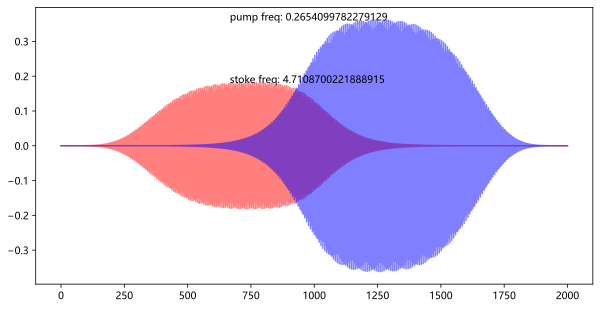

In [7]:
fig, ax = plt.subplots(1,1,figsize = (10,5))
drive_terms[0].visualize(ax=ax,tlist=tlist,args=drive_terms[0].get_pulse_shape_args_with_id(),alpha= 0.5,color='red')
drive_terms[1].visualize(ax=ax,tlist=tlist,args=drive_terms[1].get_pulse_shape_args_with_id(),alpha= 0.5,color='blue')


# problem. 4-5 and 5-6 are too close resonant

[0.00829687 0.0074375 ]


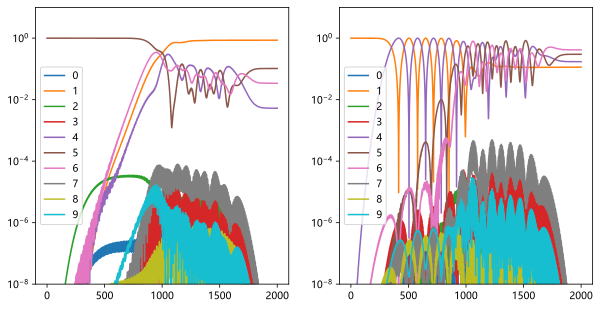

(0.14220297209875044,)
 [*********89%********   ] Elapsed 16.39s / Remaining 00:00:00:02 [*********89%********   ] Elapsed 16.32s / Remaining 00:00:00:02

In [9]:
def objective(x):    
    Rabi_freqij = x[0]
    Rabi_freqjk = x[1]
    detuning_ij = 0
    detuning_jk = 0

    results  = qbt.run_qutip_mesolve_parrallel(
        initial_states = [qutip.basis(qbt.truncated_dim, 5),
                          qutip.basis(qbt.truncated_dim, 1)
                        ],
        tlist = tlist,
        drive_terms = qbt.get_STIRAP_drive_terms(
            i = 5,
            j = 4,
            k = 1,
            t_stop = t_duration,
            Rabi_freqij=Rabi_freqij,
            Rabi_freqjk = Rabi_freqjk,
            detuning_ij = detuning_ij,
            detuning_jk = detuning_jk,
            t_start=0,
            phi=0
        ),
        # c_ops = c_ops,
        e_ops = e_ops
    )
    clear_output()
    print(x)
    fig, axes = plt.subplots(1,2,figsize = (10,5))
    for i, exp in enumerate(results[0].expect):
        axes[0].plot(tlist,exp,label= f"{i}")
    for i, exp in enumerate(results[1].expect):
        axes[1].plot(tlist,exp,label= f"{i}")
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-8,1e1)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-8,1e1)
    plt.show()
    
    one_minus_pop = 1-np.abs( results[0].expect[1][-1])
    print((one_minus_pop, ))
    return one_minus_pop

initial_guess =[0.01,0.01]

result = minimize(objective, initial_guess, method='Nelder-Mead')

# Step-2 turn on decay, compute the fidelity